In [1]:
import numpy as np
import pandas as pd
#import pylab
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

%matplotlib inline
from sklearn import linear_model, datasets
from sklearn.impute import SimpleImputer
from matplotlib.colors import LinearSegmentedColormap
import gzip
#from Bio import SeqIO
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
from my_functions import *
import random
from sklearn.utils import resample
from sklearn.metrics import r2_score


matplotlib.rcParams['text.usetex'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'cm'
#matplotlib.rcParams['font.family'] = 'cm'
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# Use relative growth calculated from appropriate Euploid control (centromere marked or not)
RG = pd.read_csv('datasets/230601_RGWT_disWT_RGssd1_disssd1.csv', index_col=0, sep='\t')
# Split Relative growth dataset to WT and ssd1
RG_WT = RG[[col for col in RG.columns if 'WT' in col]]
RG_ssd1 = RG[[col for col in RG.columns if 'ssd1' in col]]
# get a column with the number of repeats for each strain
# That's important for randomly picking the RG value later on.
RG_ssd1['nb repeats'] = RG_ssd1.count(axis='columns')
RG_WT['nb repeats'] = RG_WT.count(axis='columns')
# Calculate the average and std for each strain
# WT
mean = RG_WT[[col for col in RG_WT.columns if 'WT' in col]].mean(skipna=True, axis=1)
RG_WT['MEAN RG'] = mean
std = RG_WT[[col for col in RG_WT.columns if 'WT' in col]].std(skipna=True, axis=1)
RG_WT['STD RG'] = std
# ssd1
mean = RG_ssd1[[col for col in RG_ssd1.columns if 'ssd1' in col]].mean(skipna=True, axis=1)
RG_ssd1['MEAN RG'] = mean
std = RG_ssd1[[col for col in RG_ssd1.columns if 'ssd1' in col]].std(skipna=True, axis=1)
RG_ssd1['STD RG'] = std

RG_WT['weight'] = 1/ (RG_WT['STD RG']*RG_WT['STD RG'])
RG_ssd1['weight'] = 1/ (RG_ssd1['STD RG']*RG_ssd1['STD RG'])

C:\Users\user\AppData\Local\Temp\ipykernel_42200\2165262693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RG_ssd1['nb repeats'] = RG_ssd1.count(axis='columns')
C:\Users\user\AppData\Local\Temp\ipykernel_42200\2165262693.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RG_WT['nb repeats'] = RG_WT.count(axis='columns')
C:\Users\user\AppData\Local\Temp\ipykernel_42200\2165262693.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [3]:
mean_df = RG_WT[['MEAN RG', 'STD RG']]
mean_df = mean_df.rename(columns = {'MEAN RG': 'WT mean', 'STD RG': 'WT std'})
mean_df['ssd1 mean'] = RG_ssd1['MEAN RG']
mean_df['ssd1 std'] = RG_ssd1['STD RG']

In [4]:
mean_df.fillna(0, inplace=True)
mean_df['% decrease WT vs ssd1'] = (mean_df['WT mean'] - mean_df['ssd1 mean']) / mean_df['WT mean'] *100

In [5]:
mean_df.corr(method='spearman')

,WT mean,WT std,ssd1 mean,ssd1 std,% decrease WT vs ssd1
WT mean,1.000000,-0.370325,0.924586,0.024570,-0.635294
WT std,-0.370325,1.000000,-0.344172,0.590044,0.341176
ssd1 mean,0.924586,-0.344172,1.000000,-0.017210,-0.844118
ssd1 std,0.024570,0.590044,-0.017210,1.000000,0.157469
% decrease WT vs ssd1,-0.635294,0.341176,-0.844118,0.157469,1.000000


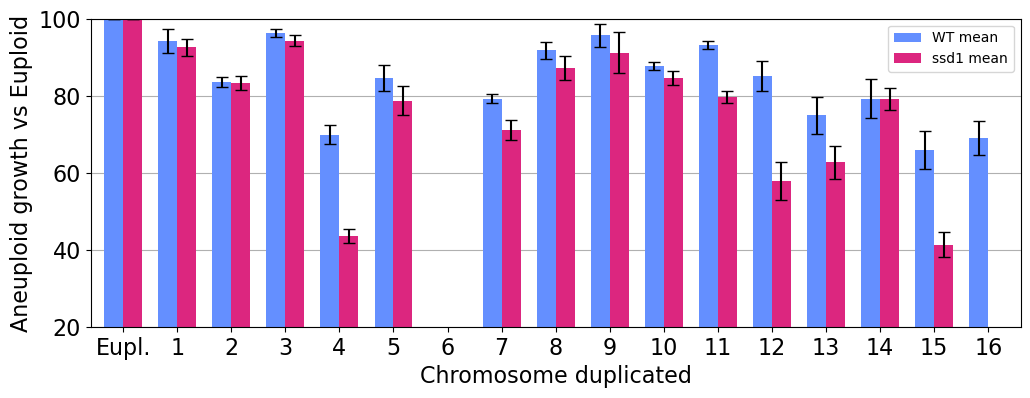

In [6]:
yerr = mean_df[['WT std', 'ssd1 std']].to_numpy().T
ax = mean_df[['WT mean', 'ssd1 mean']].plot(kind='bar', yerr=yerr, capsize=4, width =0.7, color=['#648FFF', '#DC267F'], figsize=(12,4))
ax.set_xlabel('Chromosome duplicated', fontsize=16)
ax.set_ylabel('Aneuploid growth vs Euploid', fontsize=16)
ax.set_ylim([20, 100])
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
ax.tick_params(axis='both', labelsize=16)
ax.set_xticklabels(mean_df.index, rotation=0)
ax.grid(axis='y')
#plt.savefig('plots/RG_barplot_RG_to_WT_or_ssd1del.pdf')
plt.show()

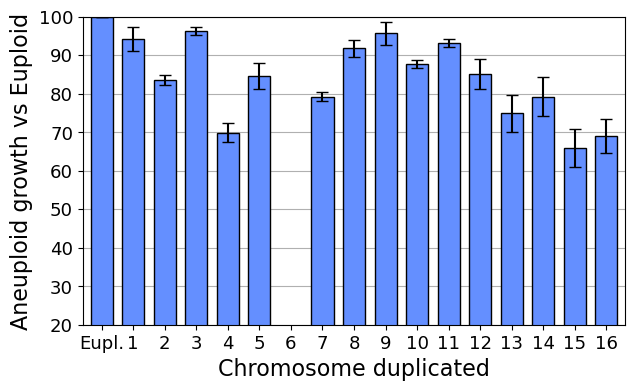

In [7]:
yerr = mean_df['WT std'].to_list()
ax = mean_df['WT mean'].plot(kind='bar', yerr=yerr, capsize=4, width =0.7, color=['#648FFF'], figsize=(7,4), edgecolor='black')
ax.set_xlabel('Chromosome duplicated', fontsize=16)
ax.set_ylabel('Aneuploid growth vs Euploid', fontsize=16)
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
ax.set_ylim([20, 100])
ax.tick_params(axis='both', labelsize=13)
ax.set_xticklabels(mean_df.index, rotation=0)
ax.grid(axis='y')
plt.savefig('plots/RG_WT_barplot.svg', bbox_inches='tight')
plt.show()

# Test set plotting

In [8]:
# Same for double disomes test set (not use to train model)
# Use relative growth calcalated from appropriate Euploid control (centromere marked or not)
test = pd.read_csv('datasets/220919_RG_6_double_disomes.csv', index_col=0, sep=',')
# Split Relative growth dataset to WT and ssd1
test_WT = test[[col for col in test.columns if 'WT' in col]]
test_ssd1 = test[[col for col in test.columns if 'ssd1' in col]]
# get a column with the number of repeats for each strain
# That's important for randomly picking the test value later on.
test_ssd1['nb repeats'] = test_ssd1.count(axis='columns')
test_WT['nb repeats'] = test_WT.count(axis='columns')
# Calculate the average and std for each strain
# WT
mean = test_WT[[col for col in test_WT.columns if 'WT' in col]].mean(skipna=True, axis=1)
test_WT['MEAN RG'] = mean
std = test_WT[[col for col in test_WT.columns if 'WT' in col]].std(skipna=True, axis=1)
test_WT['STD RG'] = std
# ssd1
mean = test_ssd1[[col for col in test_ssd1.columns if 'ssd1' in col]].mean(skipna=True, axis=1)
test_ssd1['MEAN RG'] = mean
std = test_ssd1[[col for col in test_ssd1.columns if 'ssd1' in col]].std(skipna=True, axis=1)
test_ssd1['STD RG'] = std

test_WT['weight'] = 1/ (test_WT['STD RG']*test_WT['STD RG'])
test_ssd1['weight'] = 1/ (test_ssd1['STD RG']*test_ssd1['STD RG'])

C:\Users\user\AppData\Local\Temp\ipykernel_42200\1362346965.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ssd1['nb repeats'] = test_ssd1.count(axis='columns')
C:\Users\user\AppData\Local\Temp\ipykernel_42200\1362346965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_WT['nb repeats'] = test_WT.count(axis='columns')
C:\Users\user\AppData\Local\Temp\ipykernel_42200\1362346965.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [9]:
#Remove chromosome 6
test_WT = test_WT.iloc[1: , :]
test_ssd1 = test_ssd1.iloc[1: , :]

In [10]:
mean_df_test = test_WT[['MEAN RG', 'STD RG']]
mean_df_test = mean_df_test.rename(columns = {'MEAN RG': 'WT mean', 'STD RG': 'WT std'})
mean_df_test['ssd1 mean'] = test_ssd1['MEAN RG']
mean_df_test['ssd1 std'] = test_ssd1['STD RG']

In [11]:
mean_df_test = pd.concat([mean_df, mean_df_test])

In [12]:
mean_df_test.loc[''] = [0, 0, 0, 0, 0]

In [13]:
mean_df_test

,WT mean,WT std,ssd1 mean,ssd1 std,% decrease WT vs ssd1
Chromosome,,,,,
Eupl.,100.000000,0.000000,100.000000,0.000000,0.000000
1,94.192788,3.122608,92.585234,2.196913,1.706664
2,83.603346,1.294305,83.219978,1.793647,0.458555
3,96.278806,1.089528,94.267730,1.389524,2.088805
4,69.910371,2.374512,43.484973,1.770857,37.798968
5,84.648027,3.410485,78.730516,3.857041,6.990725
6,0.000000,0.000000,0.000000,0.000000,NaN
7,79.278235,1.074495,71.189480,2.583011,10.202995
8,91.814558,2.261894,87.166300,3.035922,5.062659


In [14]:
doubleD = mean_df_test.reindex(['1', '3', '1;3', '', '4', '9', '4;9', '', '5', '8', '5;8', '', '8', '13', '8;13' ])

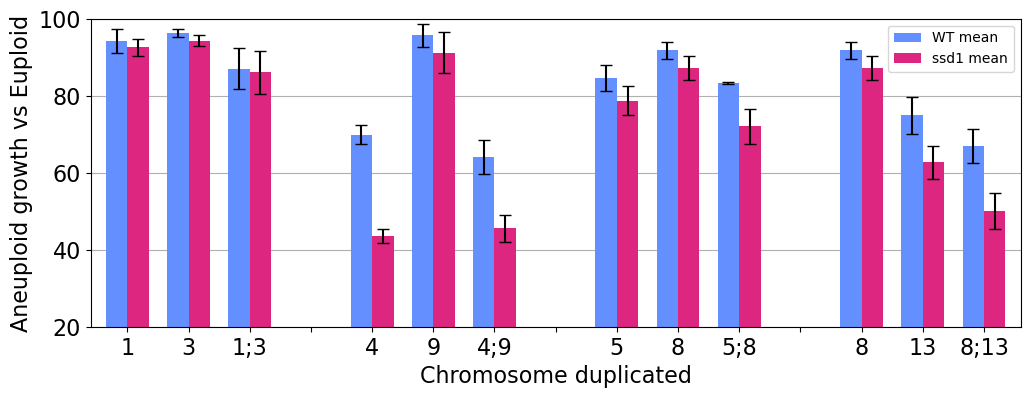

In [15]:
yerr = doubleD[['WT std', 'ssd1 std']].to_numpy().T
ax = doubleD[['WT mean', 'ssd1 mean']].plot(kind='bar', yerr=yerr, capsize=4, width =0.7, color=['#648FFF', '#DC267F'], figsize=(12,4))
ax.set_xlabel('Chromosome duplicated', fontsize=16)
ax.set_ylabel('Aneuploid growth vs Euploid', fontsize=16)
ax.set_ylim([20, 100])
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
ax.tick_params(axis='both', labelsize=16)
ax.set_xticklabels(doubleD.index, rotation=0)
ax.grid(axis='y')
plt.savefig('plots/RG_barplot_double_disomes_comp_WT_ssd1.svg')
plt.show()

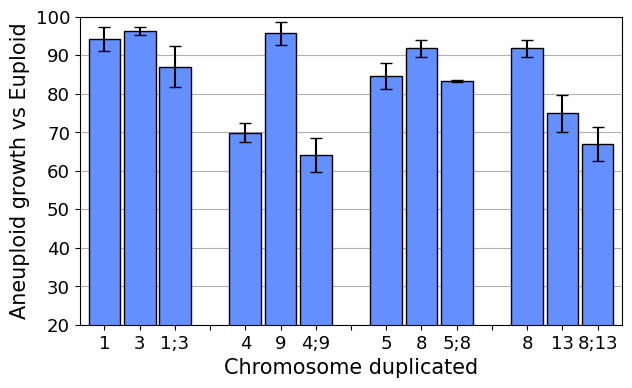

In [16]:
yerr = doubleD['WT std'].to_list()
ax = doubleD['WT mean'].plot(kind='bar', yerr=yerr, capsize=4, width=0.9, color=['#648FFF'], figsize=(7,4), linewidth=1, edgecolor='black')
ax.set_xlabel('Chromosome duplicated', fontsize=15)
ax.set_ylabel('Aneuploid growth vs Euploid', fontsize=15)
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
ax.set_ylim([20, 100])
ax.tick_params(axis='both', labelsize=13)
ax.set_xticklabels(doubleD.index, rotation=0)
ax.grid(axis='y')
plt.savefig('plots/double_dis_WT_barplot.pdf', bbox_inches='tight')
plt.show()

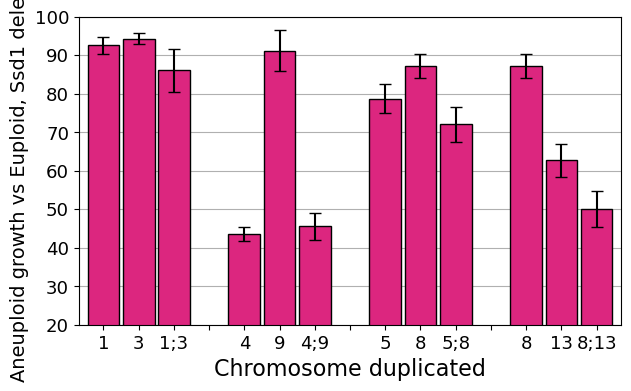

In [17]:
yerr = doubleD['ssd1 std'].to_list()
ax = doubleD['ssd1 mean'].plot(kind='bar', yerr=yerr, capsize=4, width =0.9, color='#DC267F', figsize=(7,4), linewidth=1, edgecolor='black')
ax.set_xlabel('Chromosome duplicated', fontsize=16)
ax.set_ylabel('Aneuploid growth vs Euploid, Ssd1 deletion', fontsize=14)
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
ax.set_ylim([20, 100])
ax.tick_params(axis='both', labelsize=13)
ax.set_xticklabels(doubleD.index, rotation=0)
ax.grid(axis='y')
plt.savefig('plots/double_dis_ssd1_barplot.svg', bbox_inches='tight')
plt.show()

# Load MoBy and YPS1009 gene annotation

In [18]:
# load a list of yps1009 annotated genes 
genes_yps = pd.read_csv('datasets/yps1009_genes_final.txt', index_col=0, sep='\t')
genes = genes_yps[genes_yps['orf_classification'] != 'Dubious']
# Load the normalized moby data file from Auguste
moby = pd.read_csv('datasets/EUwt.txt', sep="\t", index_col=0)
genes = genes.join(moby)

In [19]:
sign = moby[moby['FDR'] < 0.05]
toxic = sign[sign['logFC'] < 0]
benef = sign[sign['logFC'] > 0]

In [20]:
print('% toxic genes: ', toxic.shape[0]/moby.shape[0]*100)
print('% benef genes: ', benef.shape[0]/moby.shape[0]*100)

% toxic genes:  28.53695985961834
% benef genes:  25.48804562404036


In [21]:
Label = []
for index, row in moby.iterrows():
    if row['logFC'] < 0 and row['FDR'] < 0.05:
        Label.append('Toxic')
    elif row['logFC'] > 0 and row['FDR'] < 0.05:
        Label.append('Beneficial')   
    else:
        Label.append('Neutral')
moby['Label'] = Label

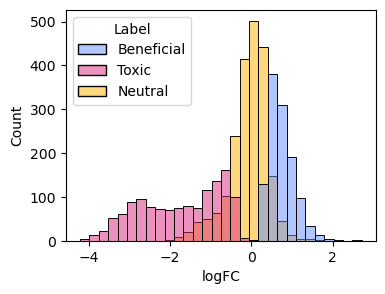

In [22]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(data=moby, x="logFC", hue='Label', bins=30, palette=["#648FFF", "#DC267F", "#FFB000"])
fig.savefig('plots/moby_histogram_benef_toxic.pdf', bbox_inches='tight')

# Melted dataset: add features and randomly select the replicates

In [23]:
# RG_melt = pd.read_csv('datasets/230601_relative_growth_repeats_updated_MELTED.csv')
# In that one, the WT aneuploid relative growth is calculated from euploid WT
# and ssd1 aneuploid relative growth is calculated from euploid ssd1
RG_melt = pd.read_csv('datasets/230601_RGWT_disWT_RGssd1_disssd1_melt.csv')

In [24]:
RG_melt.fillna(0, inplace=True)
RG_melt['% decrease WT vs ssd1'] = (RG_melt['WT'] - RG_melt['ssd1']) / RG_melt['WT'] *100

In [25]:
def Fitlin_mean(RG, cx, cy, filenamesvg=None, labels=True, alpha=1):
    X = list(RG[cx])
    y = list(RG[cy])
    n = list(RG['Chromosome'])
    
    f, ax = plt.subplots()
    ax.set(xlim=(min(X)-15, max(X)+15), ylim=(min(y)-10, max(y)+10))
    sns.regplot(x=cx, y=cy, data=RG, label=RG.index, truncate=False, scatter=False,
                color='black')
    
    mean = RG.groupby('Chromosome', as_index=False).mean()
    sns.scatterplot(x=cx, y=cy, data=mean, ax=ax, s=60, alpha=alpha, color='black', legend=False)
    
    y_m = list(mean[cy])
    x_m = list(mean[cx])
    n = list(mean['Chromosome'])
    
    if labels:
        for i in range(len(n)):
            ax.text(x_m[i] + 5, y_m[i] , n[i], horizontalalignment='center', color='black', weight='light')
    
    plt.show()
               
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    y_pred = results.predict(X)
    y_p_np = np.array(y_pred)
    y_np = np.array(y)
    
    if filenamesvg != None:
        f.savefig(filenamesvg, bbox_inches='tight')
        
    print('Parameters: ', results.params)
    print('R2: ', results.rsquared)
    print('Adjusted R2: ', results.rsquared_adj)
    print('F p-value: ', results.f_pvalue)

    return results

In [26]:
mean = RG_melt.groupby('Chromosome', as_index=False).mean()
std = RG_melt.groupby('Chromosome', as_index=False).std()
std = std.rename(columns={'% decrease WT vs ssd1': 'STD'})
mean.index = mean['Chromosome']
std.index = mean['Chromosome']
mean = mean.join(std[['STD']])

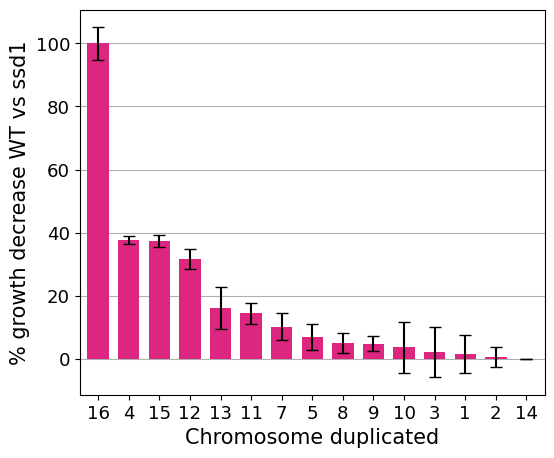

In [27]:
tmp = mean.sort_values('% decrease WT vs ssd1', ascending=False)
yerr = mean['STD'].to_list()
ax = tmp['% decrease WT vs ssd1'].plot(kind='bar', yerr=yerr, capsize=4, width =0.7, color=['#DC267F'], figsize=(6,5))
ax.set_xlabel('Chromosome duplicated', fontsize=15)
ax.set_ylabel('% growth decrease WT vs ssd1', fontsize=15)
ax.set_axisbelow(True)
#ax.set_title('Disomies fitness cost', fontsize = 15)
# ax.set_ylim([20, 100])
ax.tick_params(axis='both', labelsize=13)
ax.set_xticklabels(tmp['Chromosome'], rotation=0)
ax.grid(axis='y')
plt.savefig('plots/WT_ssd1_percent_decrease_barplot.svg', bbox_inches='tight')
plt.show()

In [28]:
# Where the computed chromosome features need to be added, first feature is ORF number
Chr_feat = pd.read_csv('datasets/yps1009_FINAL_features_per_chromosome.csv', index_col=0)
Chr_feat = Chr_feat.sort_index()
Chr_feat['verified & uncharacterized'] = Chr_feat['verified genes'] + Chr_feat['uncharacterized genes']
Chr_feat['total genes'] = Chr_feat['verified genes'] + Chr_feat['uncharacterized genes'] + Chr_feat['dubious genes']

Chr_feat.fillna(0, inplace=True)
Chr_feat['Chromosome'] = Chr_feat.index

In [29]:
tmp = RG_melt.copy()
tmp.index = tmp['Chromosome']
tmp = tmp.join(Chr_feat[['Chr length']])
tmp['Chr length (kb)'] = tmp['Chr length'] / 1000
tmp = tmp.drop(16)

In [30]:
del tmp['Chromosome']

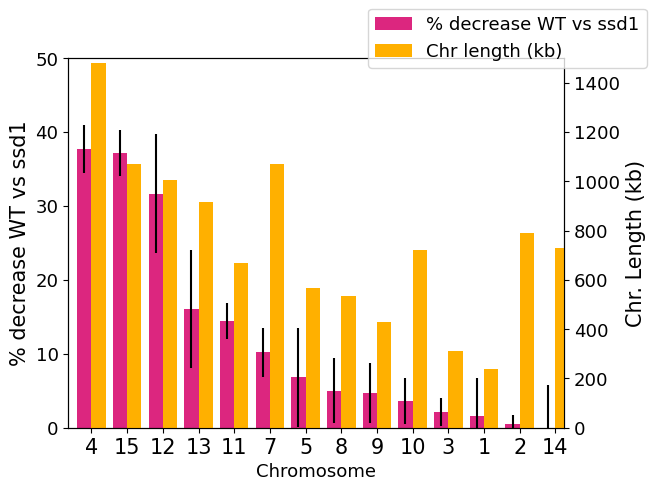

In [31]:
tmp = mean.sort_values('% decrease WT vs ssd1', ascending=False)
tmp = tmp.join(Chr_feat[['Chr length']])
tmp['Chr length (kb)'] = tmp['Chr length'] / 1000
tmp = tmp.drop(16)
yerr = tmp['STD'].to_list()

fig = plt.figure() # Create matplotlib figure
plt.rcParams.update({'font.size': 13})

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
tmp['Chr length (kb)'].plot(kind='bar', color= '#FFB000', ax=ax2, width=width, position=0)
plt.xticks(rotation=0, fontsize = 13) 
plt.yticks(rotation=0, fontsize = 13) 
tmp['% decrease WT vs ssd1'].plot(kind='bar', color='#DC267F',  yerr = yerr, width=width, ax=ax, position=1)
ax.set_xticklabels(tmp['Chromosome'], rotation=0, fontsize = 15)
ax.set_ylim(0, 50)
ax2.set_ylim(0, 1500)

#ax.legend(loc = 0, fontsize= 13)
#ax2.legend(loc = 1, fontsize=13)
fig.legend()

ax.set_ylabel('% decrease WT vs ssd1', fontsize = 15)
ax2.set_ylabel('Chr. Length (kb)', fontsize = 15)

plt.show()
fig.tight_layout()
fig.savefig('plots/barplot_chrLength_WT_ssd1_percent_decrease.svg', bbox_inches='tight')

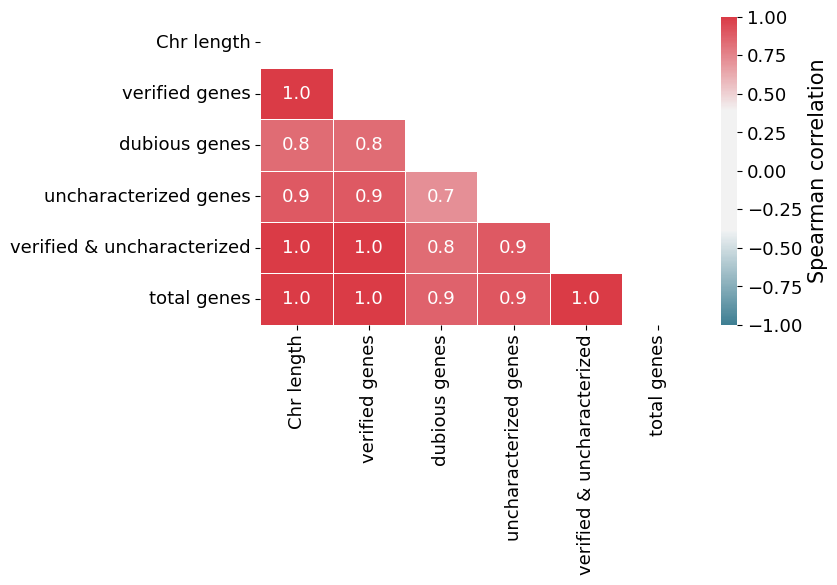

In [32]:
tmp = Chr_feat[['Chr length', 'verified genes', 'dubious genes', 'uncharacterized genes', 'verified & uncharacterized',
       'total genes']]
corr = tmp.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(7, 4))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5, annot=True, cbar_kws={'label': 'Spearman correlation'}, fmt=".1f")
ax.figure.axes[-1].yaxis.label.set_size(15)
plt.yticks(rotation=0, fontsize = 13) 
#plt.xticks(rotation=90) 
plt.show()
#fig.suptitle('Correlation matrix of features', fontsize=10)
fig.tight_layout()
# fig.savefig('plots/non_coding_spearman_corr.svg', bbox_inches='tight')

In [33]:
def Fitlin_mean2(RG1, RG2, cx, cy, ax_l, filenamesvg=None, labels=True,  alpha=1):
    X1 = list(RG1[cx])
    y1 = list(RG1[cy])
    
    X2 = list(RG2[cx])
    y2 = list(RG2[cy])
    
    colors = ['#648FFF', '#DC267F']
    
    f, ax = plt.subplots()
    ax.set(xlim=(min((X1+X2))-15, max((X1+X2))+15), ylim=(min((y1+y2))-10, max((y1+y2))+10))
    sns.regplot(x=cx, y=cy, data=RG1, label=RG1.index, truncate=False, scatter=False,
                color=colors[0])
    sns.regplot(x=cx, y=cy, data=RG2, label=RG2.index, truncate=False, scatter=False,
                color=colors[1])
    
    mean1 = RG1.groupby('Chromosome', as_index=False).mean()
    sns.scatterplot(x=cx, y=cy, data=mean1, ax=ax, s=60, alpha=alpha, color=colors[0], legend=False)
    
    mean2 = RG2.groupby('Chromosome', as_index=False).mean()
    sns.scatterplot(x=cx, y=cy, data=mean2, ax=ax, s=60, alpha=alpha, color=colors[1], legend=False)
    
    y_m1 = list(mean1[cy])
    x_m1 = list(mean1[cx])
    n1 = list(mean1['Chromosome'])
    
    y_m2 = list(mean2[cy])
    x_m2 = list(mean2[cx])
    n2 = list(mean2['Chromosome'])
    
    if labels:
        for i in range(len(n1)):
            ax.text(x_m1[i] + 10, y_m1[i] + 1, n1[i], horizontalalignment='center', color=colors[0], weight='light', fontsize= 12)
        for i in range(len(n2)):
            ax.text(x_m2[i] + 10, y_m2[i] + 1, n2[i], horizontalalignment='center', color=colors[1], weight='light', fontsize= 12)
    
               
    X1 = sm.add_constant(X1)
    results1 = sm.OLS(y1, X1).fit()
    
    X2 = sm.add_constant(X2)
    results2 = sm.OLS(y2, X2).fit()

    patch1 = mpatches.Patch(color=colors[0], label= r'$SSD1 - adj. R^2 : $ '  +  str(round(results1.rsquared_adj, 2)))
    patch2 = mpatches.Patch(color=colors[1], label= r'$ssd1\Delta - adj. R^2 : $ ' +  str(round(results2.rsquared_adj, 2)))

    plt.legend(handles=[patch1, patch2])

    plt.xlabel(ax_l[0], fontsize=15)
    plt.ylabel(ax_l[1], fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.show()
    
    if filenamesvg != None:
        f.savefig(filenamesvg, bbox_inches='tight')
        
    print('Parameters WT: ', results1.params)
    print('R2 WT: ', results1.rsquared)
    print('Adjusted R2 WT: ', results1.rsquared_adj)
    print('F p-value WT: ', results1.f_pvalue)
    
    print('Parameters ssd1: ', results2.params)
    print('R2 ssd1: ', results2.rsquared)
    print('Adjusted R2 ssd1: ', results2.rsquared_adj)
    print('F p-value ssd1: ', results2.f_pvalue)

    return results1, results2

In [34]:
del Chr_feat['Chromosome']

In [35]:
RG_melt = pd.merge(RG_melt, Chr_feat , on="Chromosome")

In [36]:
RG_melt.Chromosome.unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [37]:
RG_WT = RG_melt[['Chromosome', 'WT', 'verified genes', 'dubious genes',
       'uncharacterized genes', 'ARS', 'ltr', 'ncRNA', 'Retrotransposon', 'snoRNA',
       'tRNA', 'rRNA', 'snRNA', 'Total Features', 'Chr length', 'verified & uncharacterized',
       'total genes']]
RG_ssd1 = RG_melt[['Chromosome', 'ssd1', 'verified genes', 'dubious genes',
       'uncharacterized genes', 'ARS', 'ltr', 'ncRNA', 'Retrotransposon', 'snoRNA',
       'tRNA', 'rRNA', 'snRNA', 'Total Features', 'Chr length', 'verified & uncharacterized',
       'total genes']]

In [38]:
RG_WT = RG_WT.rename(columns={"WT": "MEAN RG"})
RG_ssd1 = RG_ssd1.rename(columns={"ssd1": "MEAN RG"})

In [39]:
RG_ssd1 = RG_ssd1[RG_ssd1['MEAN RG'].notna()]

In [40]:
# For reproducibility
np.random.seed(0)

size = 4        # that's the minimum number of replicates in my dataset
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

RG_WT = RG_WT.groupby('Chromosome', as_index=False).apply(fn)
RG_ssd1 = RG_ssd1.groupby('Chromosome', as_index=False).apply(fn)

# Melted test set

In [47]:
test_melt = pd.read_csv('datasets/220919_double_disomes_MELTED.csv', index_col=0)

In [50]:
for ind, row in test_melt.iterrows():
    print(row)
    dis = ind.split(';')

WT      90.885423
ssd1    90.240855
Name: 1;3, dtype: float64
WT      91.150598
ssd1    91.119322
Name: 1;3, dtype: float64
WT      79.634295
ssd1    79.946552
Name: 1;3, dtype: float64
WT      86.362577
ssd1    82.907373
Name: 1;3, dtype: float64
WT      66.688252
ssd1    48.491002
Name: 4;9, dtype: float64
WT      67.600130
ssd1    49.439188
Name: 4;9, dtype: float64
WT      56.771474
ssd1    40.766772
Name: 4;9, dtype: float64
WT      60.555171
ssd1    47.100029
Name: 4;9, dtype: float64
WT      66.773399
ssd1    42.215719
Name: 4;9, dtype: float64
WT      66.435256
ssd1    45.240999
Name: 4;9, dtype: float64
WT      83.183885
ssd1    72.061988
Name: 5;8, dtype: float64
WT      83.183885
ssd1    67.526668
Name: 5;8, dtype: float64
WT      83.511056
ssd1    76.460110
Name: 5;8, dtype: float64
WT      69.057783
ssd1    49.704636
Name: 8;13, dtype: float64
WT      71.792018
ssd1    43.455345
Name: 8;13, dtype: float64
WT      65.396637
ssd1    53.510556
Name: 8;13, dtype: float64
WT   

In [51]:
def Chr_to_disomes(RG, Chr_feat, column_name):
    orf = []
    for ind, row in RG.iterrows():
        dis = ind.split(';')
        genes = 0
        for d in dis:
            genes += Chr_feat._get_value(int(d), column_name)
        orf.append(genes)
    RG[column_name] = orf
    return(RG)

In [52]:
feat = ['verified genes', 'dubious genes', 'uncharacterized genes', 'ARS',
       'ltr', 'ncRNA', 'Retrotransposon', 'snoRNA', 'tRNA', 'rRNA', 'snRNA',
       'Total Features', 'Chr length', 'verified & uncharacterized', 'total genes',]
for f in feat:
    test_melt = Chr_to_disomes(test_melt, Chr_feat, f)

In [54]:
test_WT = test_melt[['WT', 'verified genes', 'dubious genes',
       'uncharacterized genes', 'ARS', 'ltr', 'ncRNA', 'Retrotransposon', 'snoRNA',
       'tRNA', 'rRNA', 'snRNA', 'Total Features', 'Chr length', 'verified & uncharacterized',
       'total genes']]
test_WT = test_WT.rename(columns= {'WT': 'MEAN RG'})
test_ssd1 = test_melt[['ssd1', 'verified genes', 'dubious genes',
       'uncharacterized genes', 'ARS', 'ltr', 'ncRNA', 'Retrotransposon', 'snoRNA',
       'tRNA', 'rRNA', 'snRNA', 'Total Features', 'Chr length', 'verified & uncharacterized',
       'total genes']]
test_ssd1 = test_ssd1.rename(columns= {'ssd1': 'MEAN RG'})

In [55]:
test_WT['Chromosome'] = test_WT.index
test_ssd1['Chromosome'] = test_ssd1.index
test_WT.reset_index(drop=True, inplace=True)
test_ssd1.reset_index(drop=True, inplace=True)

In [56]:
# For reproducibility
np.random.seed(0)

size = 3        # that's the minimum number of replicates in my dataset
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

test_WT = test_WT.groupby('Chromosome', as_index=False).apply(fn)
test_ssd1 = test_ssd1.groupby('Chromosome', as_index=False).apply(fn)

# Save the datasets

In [57]:
#RG_WT.to_csv('result_datasets/230601_RG_WT_4repeats_per_disomes.csv')
#RG_ssd1.to_csv('result_datasets/230601_RG_ssd1_4repeats_per_disomes.csv')

# the difference is that ssd1 is normalized euploid ssd1
RG_WT.to_csv('result_datasets/230601_RGWT_disWT_4repeats_per_disomes.csv', index=False)
RG_ssd1.to_csv('result_datasets/230601_RGssd1_disssd1_4repeats_per_disomes.csv', index=False)

In [58]:
test_WT.to_csv('result_datasets/220919_double_disomes_WT_3repeats.csv')
test_ssd1.to_csv('result_datasets/220919_double_disomes_ssd1_3repeats.csv')